In [1]:
!pip install wget
!pip install nptdms

In [1]:
%load_ext autoreload
%autoreload 2

import das_package as dp
import os
import numpy as np
from tqdm import tqdm
import glob
from skimage.measure import block_reduce
import matplotlib.pyplot as plt
import scipy.signal as sp
import math

# Downloading Raw Files (Download_data.ipynb)

### Task: Download the raw geoscientific dataset relevant to your project and discuss the basic modalities.

In [2]:
interrogator = "Optasense"     #Optasense or Silixa
ship_number = 1
folder = f"Data/Raw/Ship{ship_number}"
results_folder = f"{folder}/results"
if not os.path.exists(results_folder):
    os.makedirs(results_folder)
url = "http://piweb.ooirsn.uw.edu/das/data/Optasense/SouthCable/TransmitFiber/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-01T16_09_15-0700/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012014Z.h5"
first_file_time = dp.find_time_url(url, interrogator)
file_timing_length = 60
minutes = 1
n = int(minutes*60/file_timing_length)
all_filenames = dp.dl_das_files(folder, url, first_file_time, file_timing_length, n)
filenames = sorted([file for file in all_filenames if file != f"{folder}/results"])
print(filenames)

Downloaded South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012014Z.h5
['Data/Raw/Ship1/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012014Z.h5']


# Loading Raw Data (Data_Cleaning.ipynb)

### Task: Clean the raw data to handle missing values, outliers, or inconsistencies.



In [3]:
if interrogator == 'Optasense':
    rawData, dt, fs, dx, nx, ns, GL, sf, starting_time_timestamp = dp.optasense(filenames)

elif interrogator == 'Silixa':
    rawData, dt, fs, dx, nx, ns, GL, sf, starting_time_timestamp = dp.silixa(filenames)


# Downsample factors and channel chunking size
if fs == 1000:
    factor_channels = 2
    factor_time = 5
    ch_chunk_size = 500
elif fs == 500:
    factor_channels = 2
    factor_time = 2
    ch_chunk_size = 700
elif fs == 200:
    factor_channels = 2
    factor_time = 1
    ch_chunk_size = 1000

The concatenated data shape: (47500, 12000)
The first value in "RawDataTime" is 1635902414834000 which is the timestamp of the first sample in microseconds.
This equates to the date and time 2021-11-03 01:20:14.834000
the time step is equal to =  5000.0 microsecond

sampling rate in Hz =  200.0
channel spacing in m =  2.0419047
number of channels =  47500
number of samples in each channel =  12000
gauge length in m =  51.04762


# Converting Raw Data to AI-Ready Data (Prepare_AI_Ready_Data.ipynb)

### Task: Prepare the cleaned data for machine learning, ensuring it is properly annotated and structured.

In [10]:
distance = [0, nx*dx]
if dx<2:
    chint = 1
elif dx>=2:
    chint = 1
duration = [0, int(ns/fs)]            #in second1
tint = 1                         #time interval (sample)


#Converting selected distance from meter to channels
channels = [int(distance[0]/dx), int(distance[1]/dx), chint]
print(f"channels = {channels}")

#Finding number of itterations
itteration = (((channels[1] - channels[0]) / chint)//ch_chunk_size)
print('Number of itterations: ', itteration)


### Raw to strain rate ###
#Determine the first chunck of data
channels_chunk = [int(distance[0]/dx), min(int(distance[0]/dx) + ch_chunk_size*chint , int(distance[1]/dx)), chint]
time_chunk = [int(duration[0]*fs), int(duration[1]*fs), tint]

#Doing analysis for first chunk of data
trace, dist_whole, time_whole, starting_time_utc = dp.chunk_load(rawData, channels_chunk, time_chunk, dt, fs, dx, sf, starting_time_timestamp)
if interrogator == 'Optasense':
    str_rate_whole = dp.strain2strainrate(trace, dt, tint)
elif interrogator == 'Silixa':
    str_rate_whole = trace

#Doing analysis for remained chunks of data
for i in tqdm(range(int(itteration))):

    if (channels_chunk[1] + ch_chunk_size*chint)*dx >= distance[1]:
        channels_chunk = [channels_chunk[1], int(distance[1]/dx), chint]
    else:
        channels_chunk = [channels_chunk[1], channels_chunk[1] + ch_chunk_size*chint, chint]

    if channels_chunk[1] - channels_chunk[0] < 0.1*ch_chunk_size :
        break

    trace, dist_chunk, time_whole, starting_time_utc = dp.chunk_load(rawData, channels_chunk, time_chunk, dt, fs, dx, sf, starting_time_timestamp)
    dist_whole = np.concatenate([dist_whole, dist_chunk])
    if interrogator == 'Optasense':
        str_rate_chunk = dp.strain2strainrate(trace, dt, tint)
    elif interrogator == 'Silixa':
        str_rate_chunk = trace
    str_rate_whole = np.concatenate([str_rate_whole, str_rate_chunk], axis=0)
    del str_rate_chunk, dist_chunk

np.save(f'{folder}/results/str_rate{ship_number}_whole', str_rate_whole)
np.save(f'{folder}/results/time{ship_number}_whole', time_whole)
np.save(f'{folder}/results/dist{ship_number}_whole', dist_whole)

# del trace, rawData

# if interrogator == 'Optasense':
#     files = glob.glob(os.path.join(folder, '*.h5'))
#     print(files)
#     for file in files:
#         os.remove(file)

# elif interrogator == 'Silixa':
#     files = glob.glob(os.path.join(folder, '*.tdms'))
#     print(files)
#     for file in files:
#         os.remove(file)


channels = [0, 47500, 1]
Number of itterations:  47.0


100%|██████████| 47/47 [25:16<00:00, 32.26s/it]


In [11]:
distance = [50000, 55000]
if dx<2:
    chint = 1
elif dx>=2:
    chint = 1
duration = [0, int(ns/fs)]            #in second1
tint = 1                         #time interval (sample)


#Converting selected distance from meter to channels
channels = [int(distance[0]/dx), int(distance[1]/dx), chint]
print(f"channels = {channels}")

#Finding number of itterations
itteration = (((channels[1] - channels[0]) / chint)//ch_chunk_size)
print('Number of itterations: ', itteration)


### Raw to strain rate ###
#Determine the first chunck of data
channels_chunk = [int(distance[0]/dx), min(int(distance[0]/dx) + ch_chunk_size*chint , int(distance[1]/dx)), chint]
time_chunk = [int(duration[0]*fs), int(duration[1]*fs), tint]

#Doing analysis for first chunk of data
trace, dist_ship, time_ship, starting_time_utc = dp.chunk_load(rawData, channels_chunk, time_chunk, dt, fs, dx, sf, starting_time_timestamp)
if interrogator == 'Optasense':
    str_rate_ship = dp.strain2strainrate(trace, dt, tint)
elif interrogator == 'Silixa':
    str_rate_ship = trace

#Doing analysis for remained chunks of data
for i in tqdm(range(int(itteration))):

    if (channels_chunk[1] + ch_chunk_size*chint)*dx >= distance[1]:
        channels_chunk = [channels_chunk[1], int(distance[1]/dx), chint]
    else:
        channels_chunk = [channels_chunk[1], channels_chunk[1] + ch_chunk_size*chint, chint]

    if channels_chunk[1] - channels_chunk[0] < 0.1*ch_chunk_size :
        break

    trace, dist_chunk, time_ship, starting_time_utc = dp.chunk_load(rawData, channels_chunk, time_chunk, dt, fs, dx, sf, starting_time_timestamp)
    dist_ship = np.concatenate([dist_ship, dist_chunk])
    if interrogator == 'Optasense':
        str_rate_chunk = dp.strain2strainrate(trace, dt, tint)
    elif interrogator == 'Silixa':
        str_rate_chunk = trace
    str_rate_ship = np.concatenate([str_rate_ship, str_rate_chunk], axis=0)
    del str_rate_chunk, dist_chunk

np.save(f'{folder}/results/str_rate{ship_number}_ship', str_rate_ship)
np.save(f'{folder}/results/time{ship_number}_ship', time_ship)
np.save(f'{folder}/results/dist{ship_number}_ship', dist_ship)

del trace, rawData

if interrogator == 'Optasense':
    files = glob.glob(os.path.join(folder, '*.h5'))
    print(files)
    for file in files:
        os.remove(file)

elif interrogator == 'Silixa':
    files = glob.glob(os.path.join(folder, '*.tdms'))
    print(files)
    for file in files:
        os.remove(file)


channels = [24486, 26935, 1]
Number of itterations:  2.0


100%|██████████| 2/2 [01:12<00:00, 36.41s/it]

['Data/Raw/Ship1/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012114Z.h5', 'Data/Raw/Ship1/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012414Z.h5', 'Data/Raw/Ship1/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012314Z.h5', 'Data/Raw/Ship1/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012214Z.h5', 'Data/Raw/Ship1/South-C1-LR-95km-P1kHz-GL50m-SP2m-FS200Hz_2021-11-03T012014Z.h5']


## Loading the data

In [4]:
q = 1

str_rate_whole = np.load(f'{folder}/results/str_rate{q}_whole.npy')
time_whole = np.load(f'{folder}/results/time{q}_whole.npy')
dist_whole = np.load(f'{folder}/results/dist{q}_whole.npy')

str_rate_ship = np.load(f'{folder}/results/str_rate{q}_ship.npy')
time_ship = np.load(f'{folder}/results/time{q}_ship.npy')
dist_ship = np.load(f'{folder}/results/dist{q}_ship.npy')

## Downsampling the Data (Dimensionality_Reduction.ipynb)

### Task: Analyze the dimensionality of your dataset and propose methods to reduce it.



In [12]:
print(f"size of whole data: {str_rate_whole.shape}")
print(f"size of ship signal in data: {str_rate_ship.shape}")

size of whole data: (47500, 60000)
size of ship signal in data: (2449, 60000)


In [6]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
scaled_data_whole = scaler.fit_transform(str_rate_whole)

# Step 1: Temporal PCA
temporal_pca = PCA(n_components=int(str_rate_whole.shape[0]/100))
data_temporal_reduced = temporal_pca.fit_transform(scaled_data_whole.T).T  # Reduce time

# Step 2: Spatial PCA
spatial_pca = PCA(n_components=int(str_rate_whole.shape[1]/6000))
data_reduced_whole = spatial_pca.fit_transform(data_temporal_reduced)

In [8]:
dist_reduced_whole = block_reduce(dist_whole, block_size=math.ceil(str_rate_whole.shape[0]/data_reduced_whole.shape[0]), func=np.mean)
time_reduced_whole = block_reduce(time_whole, block_size=6000, func=np.mean)

In [9]:
scaler = StandardScaler()
scaled_data_ship = scaler.fit_transform(str_rate_ship)

# Step 1: Temporal PCA
temporal_pca = PCA(n_components=int(str_rate_ship.shape[0]/100))
data_temporal_reduced = temporal_pca.fit_transform(scaled_data_ship.T).T  # Reduce time

# Step 2: Spatial PCA
spatial_pca = PCA(n_components=int(str_rate_ship.shape[1]/6000))
data_reduced_ship = spatial_pca.fit_transform(data_temporal_reduced)

In [10]:
dist_reduced_ship = block_reduce(dist_ship, block_size=math.ceil(str_rate_ship.shape[0]/data_reduced_ship.shape[0]), func=np.mean)
time_reduced_ship = block_reduce(time_ship, block_size=6000, func=np.mean)

In [12]:
print(f"whole data reduced size: {data_reduced_whole.shape}")
print(f"whole distance reduced size: {dist_reduced_whole.shape}")
print(f"whole time reduced size: {time_reduced_whole.shape}")

whole data reduced size: (113, 10)
whole distance reduced size: (113,)
whole time reduced size: (10,)


In [13]:
print(f"ship data reduced size: {data_reduced_ship.shape}")
print(f"ship distance reduced size: {dist_reduced_ship.shape}")
print(f"ship time reduced size: {time_reduced_ship.shape}")

ship data reduced size: (24, 10)
ship distance reduced size: (24,)
ship time reduced size: (10,)


# Exploratory Data Analysis

### Task: Perform a basic exploration of the cleaned data to understand its structure and key characteristics.

## Visualization of actual whole data

<function matplotlib.pyplot.show(close=None, block=None)>

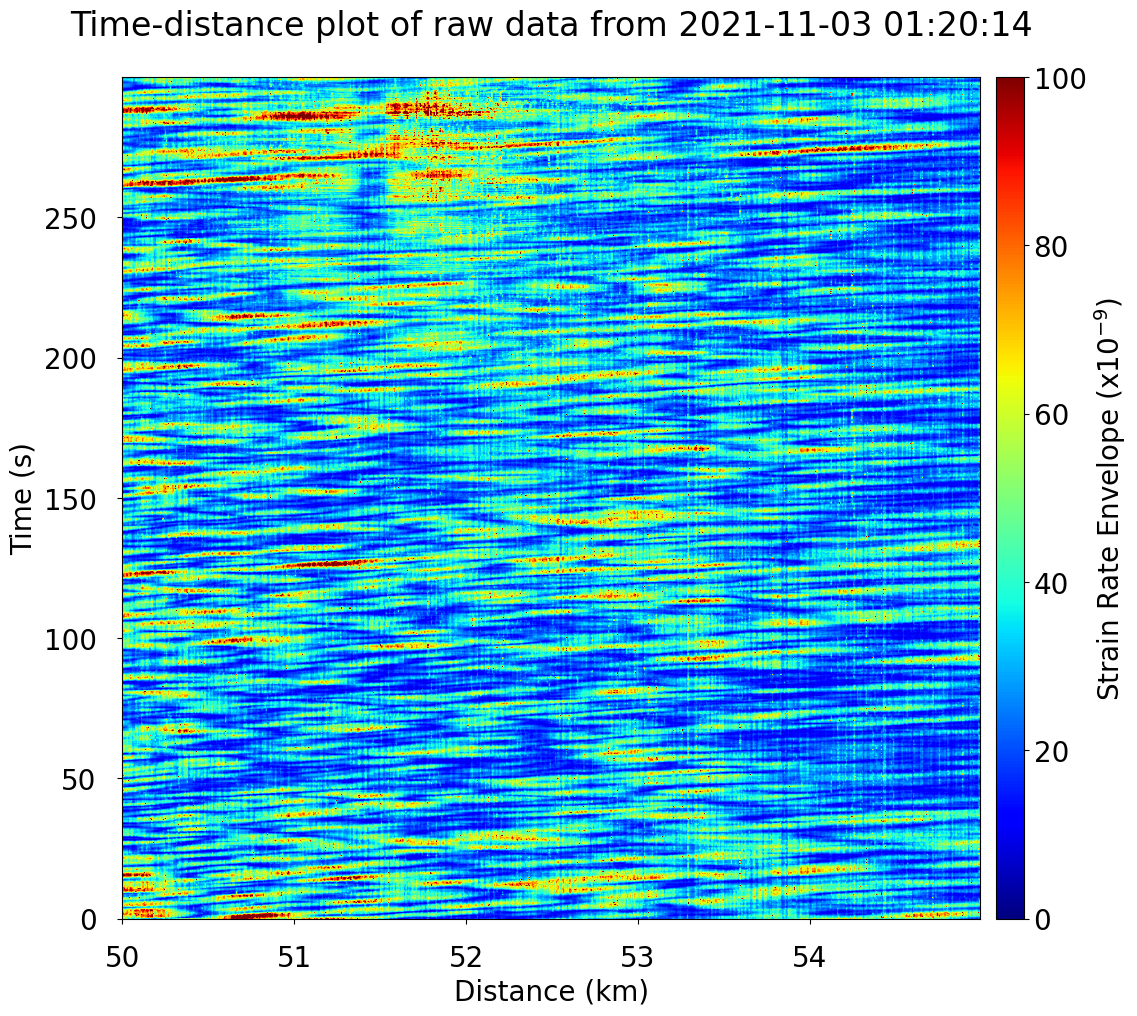

In [16]:
vmax = 100
dp.plot_tx(sp.hilbert(str_rate_whole[0:-2,:], axis=1), time_whole, dist_whole[0:-2], file_begin_time_utc=starting_time_utc, fig_size=(12, 10), v_min=0, v_max=vmax)
plt.title(f'Time-distance plot of whole raw data from {starting_time_utc.strftime("%Y-%m-%d %H:%M:%S")}', pad=30)
plt.show

## Visualization of actual ship data

In [ ]:
vmax = 100
dp.plot_tx(sp.hilbert(str_rate_ship[0:-2,:], axis=1), time_ship, dist_ship[0:-2], file_begin_time_utc=starting_time_utc, fig_size=(12, 10), v_min=0, v_max=vmax)
plt.title(f'Time-distance plot of ship raw data from {starting_time_utc.strftime("%Y-%m-%d %H:%M:%S")}', pad=30)
plt.show

## Visualization of reduced whole data

<function matplotlib.pyplot.show(close=None, block=None)>

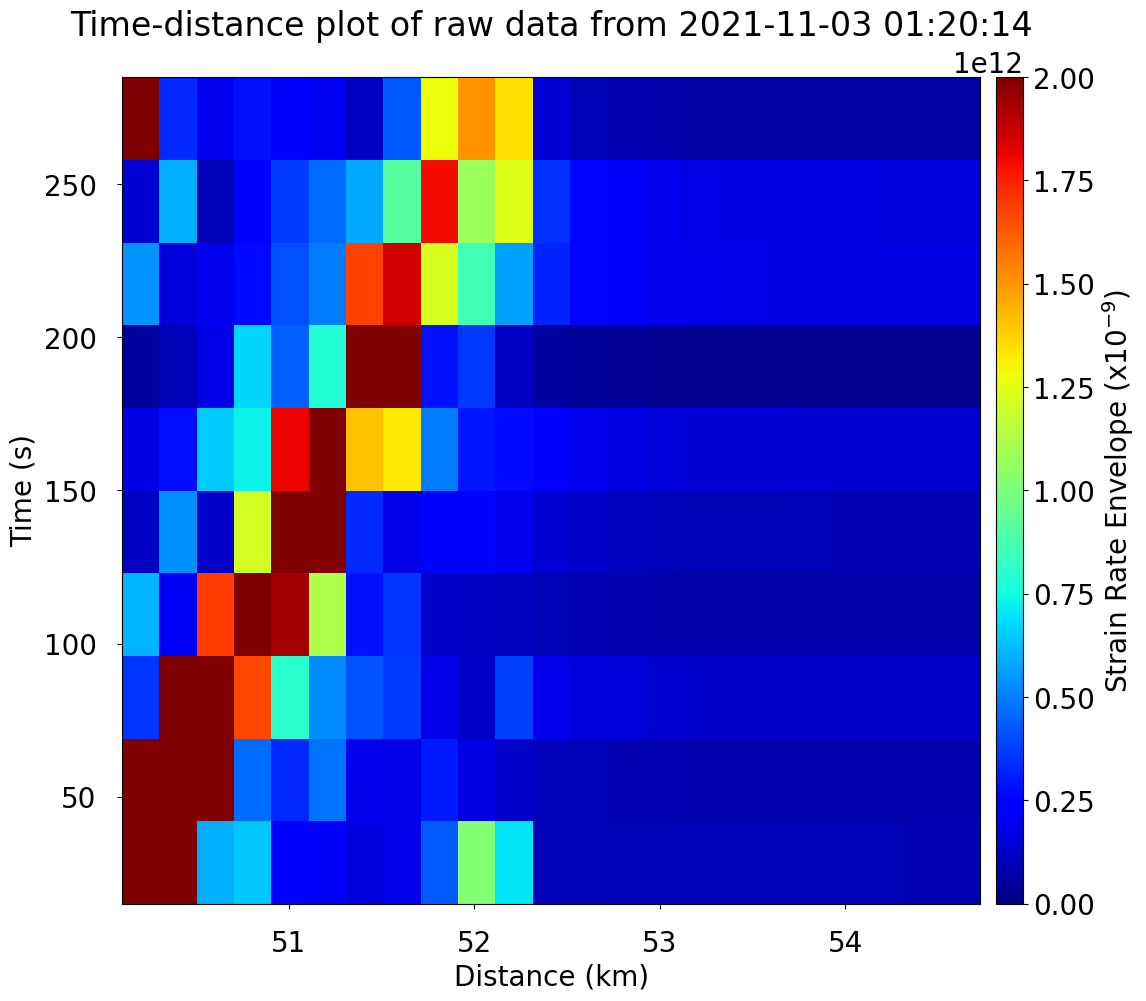

In [49]:
vmax = 2e12
dp.plot_tx(sp.hilbert(data_reduced_whole[0:-1,:], axis=1), time_reduced_whole, dist_reduced_whole[0:-1], file_begin_time_utc=starting_time_utc, fig_size=(12, 10), v_min=0, v_max=vmax)
plt.title(f'Time-distance plot of raw reduced whole data from {starting_time_utc.strftime("%Y-%m-%d %H:%M:%S")}', pad=30)
plt.show

## Visualization of reduced ship data

In [ ]:
vmax = 2e12
dp.plot_tx(sp.hilbert(data_reduced_ship[0:-1,:], axis=1), time_reduced_ship, dist_reduced_ship[0:-1], file_begin_time_utc=starting_time_utc, fig_size=(12, 10), v_min=0, v_max=vmax)
plt.title(f'Time-distance plot of raw reduced ship data from {starting_time_utc.strftime("%Y-%m-%d %H:%M:%S")}', pad=30)
plt.show

## f-k plot

In [8]:
# Calculating FFT of the raw data
nnx, nns = str_rate.shape
fk_trace = np.fft.fftshift(np.fft.fft2(str_rate))
freq = np.fft.fftshift(np.fft.fftfreq(nns, d=1 / fs))
knum = np.fft.fftshift(np.fft.fftfreq(nnx, d=channels_chunk[2] * dx))

<function matplotlib.pyplot.show(close=None, block=None)>

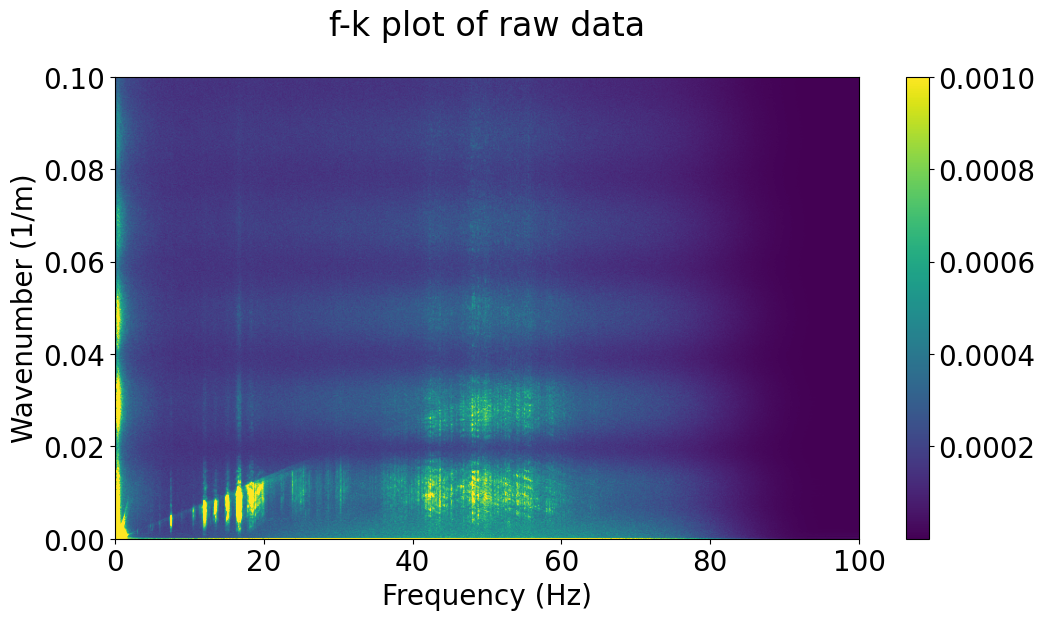

In [9]:
frq_max = 100
frq_min = 0
vmax = 0.001

# Plot the f-k spectrum
plt.figure(figsize=(12, 6))
shw = plt.imshow(np.abs(fk_trace), aspect='auto', extent=[freq[0], freq[-1], knum[0], knum[-1]], origin='lower', vmin=None, vmax=vmax)
plt.colorbar(shw)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Wavenumber (1/m)')
plt.xlim(frq_min, min(frq_max, fs/2))
plt.ylim(0, min(frq_max*0.001, 1/(2*dx)))
plt.title(f'f-k plot of raw data', pad=30)
plt.show

# Logistic Regression for Classification Projects (Clustering_Analysis.ipnyb)
### Task: If your project involves classification, perform a clustering analysis on the features of your data, especially after dimensionality reduction.

In [20]:
import torch
import numpy as np
import pandas as pd
from math import exp
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_fscore_support

In [7]:
data = str_rate_whole
# data.dropna(inplace=True)
# data.reset_index(inplace=True, drop=True)
x = str_rate_whole
y = np.zeros(str_rate_whole.shape[0])
y[int(50000/dx):int(54000/dx)] = 1
N = len(data)

In [8]:
print(y[25050])

1.0


In [20]:
scaler = preprocessing.StandardScaler().fit(x)
x = scaler.transform(x)

In [9]:
model = LogisticRegression(random_state=0).fit(x, y)

In [10]:
model.coef_

array([[-3.18955470e-08, -3.02344492e-08, -2.97848953e-08, ...,
         2.44293711e-08,  4.23367305e-08,  6.40952569e-08]])

In [11]:
model.intercept_

array([-3.14600331])

In [12]:
yhat = model.predict(x)

In [13]:
metrics = precision_recall_fscore_support(y, yhat, average='binary')

/gscratch/coenv/erfanbh/miniconda/envs/odl/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Visualization:
### Since the complete dataset is too large to train at this stage, we used a random subset of the data to demonstrate that the code is functional. In the future, after completing additional steps such as labeling the data and gaining access to a high-performance computing (HPC) system, we will be able to process the full dataset and present the results.